In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Cleaning

In [86]:

GDP_Data = pd.read_csv('RGDP_Data.csv', skiprows=3) #this is real GDP n 2015 USD
Capital_Stock_Data = pd.read_csv('Capital_Stock_Data.csv', skiprows=3)
Gross_Savings_Data = pd.read_csv('Gross_Savings_Data.csv', skiprows=3)
Population_Data = pd.read_csv('Population_Data.csv', skiprows=3)
Labor_Force_Data = pd.read_csv('Labor_Force_Data.csv', skiprows=3)

# List of countries to include
selected_countries = [
    "United States", "Germany", "Japan", "Australia", "Canada", "Saudi Arabia", "Poland", "Greece",
    "Brazil", "China", "South Africa", "Russia", "Argentina", "Mexico", "Turkey", "Thailand", "Colombia",
    "India", "Egypt", "Bangladesh", "Vietnam", "Kenya", "Indonesia",
    "Uganda", "Mozambique", "Rwanda", "Madagascar", "Tanzania"
]

# Filter for the selected countries
GDP_Data1 = GDP_Data[GDP_Data['Country Name'].isin(selected_countries)]
Capital_Stock_Data1 = Capital_Stock_Data[Capital_Stock_Data['Country Name'].isin(selected_countries)]
Gross_Savings_Data1 = Gross_Savings_Data[Gross_Savings_Data['Country Name'].isin(selected_countries)]
Population_Data1 = Population_Data[Population_Data['Country Name'].isin(selected_countries)]
Labor_Force_Data1 = Labor_Force_Data[Labor_Force_Data['Country Name'].isin(selected_countries)]

# Select the first three columns, plus the columns within the year range 1992-2023
columns_GDP = ["Country Name", "Country Code", "Indicator Name"] + \
              [col for col in GDP_Data.columns if col.isdigit() and 1992 <= int(col) <= 2023]

columns_GDI = ["Country Name", "Country Code", "Indicator Name"] + \
              [col for col in Capital_Stock_Data.columns if col.isdigit() and 1992 <= int(col) <= 2023]

columns_Pop = ["Country Name", "Country Code", "Indicator Name"] + \
              [col for col in Population_Data.columns if col.isdigit() and 1990 <= int(col) <= 2023]

columns_savings = ["Country Name", "Country Code", "Indicator Name"] + \
                  [col for col in Gross_Savings_Data.columns if col.isdigit() and 1991 <= int(col) <= 2023]

columns_labor = ["Country Name", "Country Code", "Indicator Name"] + \
                [col for col in Labor_Force_Data.columns if col.isdigit() and 1990 <= int(col) <= 2023]

# Apply the columns filter to each dataset
GDP_Data2 = GDP_Data1[columns_GDP]
Capital_Stock_Data2 = Capital_Stock_Data1[columns_GDP]
Population_Data2 = Population_Data1[columns_Pop]
Gross_Savings_Data2 = Gross_Savings_Data1[columns_savings]
Labor_Force_Data2 = Labor_Force_Data1[columns_labor]


In [87]:
# Define a function to calculate annual growth starting from 1992 since we need previous year's data (1991)
def calculate_annual_growth(row):
    growth_rates = {}
    # For 1992 to 2023, we compute growth using the previous year
    for year in range(1992, 2024):
        prev_year = str(year - 1)
        current_year = str(year)
        # Check for non-null and numeric data
        if (prev_year in row and current_year in row and
            pd.notnull(row[prev_year]) and pd.notnull(row[current_year]) and
            row[prev_year] != 0):
            growth_rates[current_year] = (row[current_year] - row[prev_year]) / row[prev_year]
        else:
            growth_rates[current_year] = pd.NA
    return pd.Series(growth_rates)

# Create Population Growth Data
Population_Growth_Data = Population_Data2.apply(calculate_annual_growth, axis=1)
Population_Growth_Data = pd.concat([Population_Data2[["Country Name", "Country Code", "Indicator Name"]], Population_Growth_Data], axis=1)
Population_Growth_Data["Indicator Name"] = Population_Growth_Data["Indicator Name"].replace("Population, total", "Pop Annual Growth Rate")

# Create Labor Force Growth Data
Labor_Force_Growth_Data = Labor_Force_Data2.apply(calculate_annual_growth, axis=1)
Labor_Force_Growth_Data = pd.concat([Labor_Force_Data2[["Country Name", "Country Code", "Indicator Name"]], Labor_Force_Growth_Data], axis=1)
Labor_Force_Growth_Data["Indicator Name"] = Labor_Force_Growth_Data["Indicator Name"].replace("Labor force, total", "Labor Annual Growth Rate")

# Define a function to calculate savings rate from total savings and total GDP
def calculate_savings_rate(row):
    savings_rate = {}
    for year in range(1992, 2024):
        year_str = str(year)
        if year_str in row and year_str in GDP_Data2.columns:
            gdp_value = GDP_Data2.loc[row.name, year_str]
            if pd.notnull(gdp_value) and gdp_value != 0 and pd.notnull(row[year_str]):
                savings_rate[year_str] = (row[year_str] / gdp_value)
            else:
                savings_rate[year_str] = pd.NA
        else:
            savings_rate[year_str] = pd.NA
    return pd.Series(savings_rate)

# Create Savings Rate Data
Savings_Rate_Data = Gross_Savings_Data2.iloc[:, 3:].apply(calculate_savings_rate, axis=1)
Savings_Rate_Data = pd.concat([Gross_Savings_Data2[["Country Name", "Country Code", "Indicator Name"]], Savings_Rate_Data], axis=1)

# Save the resulting datasets to an intermediate Excel file
with pd.ExcelWriter('Project_Data.xlsx') as writer:
    GDP_Data2.to_excel(writer, sheet_name='GDP Data', index=False)
    Capital_Stock_Data2.to_excel(writer, sheet_name='Capital Stock Data', index=False)
    Savings_Rate_Data.to_excel(writer, sheet_name='Savings Rate Data', index=False)
    Population_Growth_Data.to_excel(writer, sheet_name='Population Growth Rate Data', index=False)
    Labor_Force_Growth_Data.to_excel(writer, sheet_name='Labour Growth Rate Data', index=False)
    Labor_Force_Data2.to_excel(writer, sheet_name='Labour Data', index=False)

In [88]:
# Load each cleaned dataset
GDP_Data_Cleaned = pd.read_excel('Project_Data.xlsx', sheet_name='GDP Data')
Capital_Stock_Data_Cleaned = pd.read_excel('Project_Data.xlsx', sheet_name='Capital Stock Data')
Gross_Savings_Data_Cleaned = pd.read_excel('Project_Data.xlsx', sheet_name='Savings Rate Data')
Population_Data_Cleaned = pd.read_excel('Project_Data.xlsx', sheet_name='Population Growth Rate Data')
Labor_Force_Data_Cleaned = pd.read_excel('Project_Data.xlsx', sheet_name='Labour Growth Rate Data')
Labor_Force_Data2_Cleaned = pd.read_excel('Project_Data.xlsx', sheet_name='Labour Data') 

# Define a helper function to melt a dataframe from wide to long format
def melt_data(df, value_name):
    id_vars = ["Country Name", "Country Code", "Indicator Name"]
    year_cols = [col for col in df.columns if col.isdigit()]
    df_melted = df.melt(id_vars=id_vars, value_vars=year_cols, var_name="Year", value_name=value_name)
    df_melted["Year"] = pd.to_numeric(df_melted["Year"], errors='coerce')
    df_melted = df_melted.drop(columns=["Indicator Name"])
    return df_melted

# Melt each dataset to long format
gdp_long = melt_data(GDP_Data_Cleaned, "GDP")
capital_long = melt_data(Capital_Stock_Data_Cleaned, "Capital Stock")
savings_long = melt_data(Gross_Savings_Data_Cleaned, "Savings Rate")
population_long = melt_data(Population_Data_Cleaned, "Pop Growth Rate")
labor_long = melt_data(Labor_Force_Data_Cleaned, "Labour Force Growth Rate")
labor_long2 = melt_data(Labor_Force_Data2_Cleaned, "Labour Force")

# Merge all datasets on Country Name, Country Code, and Year
merged_df = gdp_long.merge(capital_long, on=["Country Name", "Country Code", "Year"], how="left") \
                    .merge(savings_long, on=["Country Name", "Country Code", "Year"], how="left") \
                    .merge(labor_long, on=["Country Name", "Country Code", "Year"], how="left") \
                    .merge(population_long, on=["Country Name", "Country Code", "Year"], how="left") \
                    .merge(labor_long2, on=["Country Name", "Country Code", "Year"], how="left")

# Sort by Country Name and Year
merged_df.sort_values(["Country Name", "Year"], inplace=True)

# Save the final merged dataset
merged_df.to_excel("Final_Dataset.xlsx", index=False)

In [89]:
df = pd.read_excel("Final_Dataset.xlsx")
df.head()

,Country Name,Country Code,Year,GDP,Capital Stock,Savings Rate,Labour Force Growth Rate,Pop Growth Rate,Labour Force
0,Argentina,ARG,1992,313120000000,3.821158e+10,0.110822,0.029395,0.013971,14275486
1,Argentina,ARG,1993,338818000000,4.660997e+10,0.120766,0.029565,0.013672,14697546
2,Argentina,ARG,1994,358592000000,5.139950e+10,0.121265,0.025143,0.013561,15067090
3,Argentina,ARG,1995,348389000000,4.773693e+10,0.133980,0.008917,0.013263,15201443
4,Argentina,ARG,1996,367644000000,5.340632e+10,0.140460,0.023820,0.012684,15563537


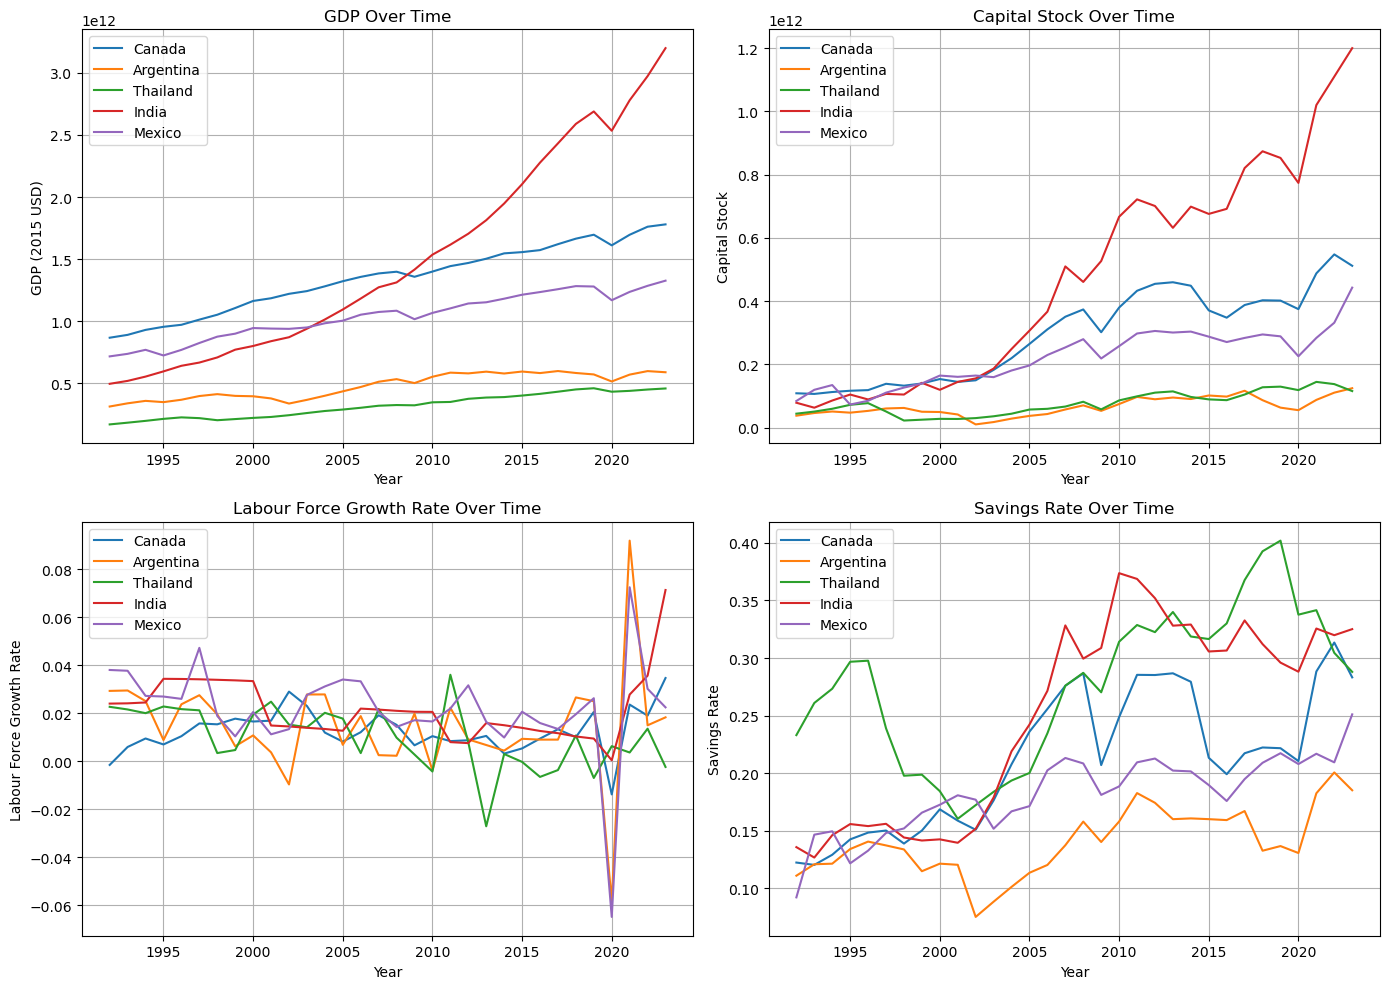

In [90]:
countries_to_plot = ["Canada", "Argentina", "Thailand", "India", "Mexico"]

# Filter the dataframe for these countries
plot_df = df[df["Country Name"].isin(countries_to_plot)]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
ax_gdp, ax_capital, ax_lfg, ax_savings = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]

# Plot GDP
for country in countries_to_plot:
    country_data = plot_df[plot_df["Country Name"] == country].sort_values("Year")
    ax_gdp.plot(country_data["Year"], country_data["GDP"], label=country)
ax_gdp.set_title("GDP Over Time")
ax_gdp.set_xlabel("Year")
ax_gdp.set_ylabel("GDP (2015 USD)")
ax_gdp.grid(True)
ax_gdp.legend()

# Plot Capital Stock
for country in countries_to_plot:
    country_data = plot_df[plot_df["Country Name"] == country].sort_values("Year")
    ax_capital.plot(country_data["Year"], country_data["Capital Stock"], label=country)
ax_capital.set_title("Capital Stock Over Time")
ax_capital.set_xlabel("Year")
ax_capital.set_ylabel("Capital Stock")
ax_capital.grid(True)
ax_capital.legend()

# Plot Labour Force Growth Rate
for country in countries_to_plot:
    country_data = plot_df[plot_df["Country Name"] == country].sort_values("Year")
    ax_lfg.plot(country_data["Year"], country_data["Labour Force Growth Rate"], label=country)
ax_lfg.set_title("Labour Force Growth Rate Over Time")
ax_lfg.set_xlabel("Year")
ax_lfg.set_ylabel("Labour Force Growth Rate")
ax_lfg.grid(True)
ax_lfg.legend()

# Plot Savings Rate
for country in countries_to_plot:
    country_data = plot_df[plot_df["Country Name"] == country].sort_values("Year")
    ax_savings.plot(country_data["Year"], country_data["Savings Rate"], label=country)
ax_savings.set_title("Savings Rate Over Time")
ax_savings.set_xlabel("Year")
ax_savings.set_ylabel("Savings Rate")
ax_savings.grid(True)
ax_savings.legend()

plt.tight_layout()
plt.show()


# Formula

To make a prediction model for a country's steady state condition, we must first define the steady-state condition of a economy. The idea focuses on the Cobb-Douglas function which we are familiar with (from lectures).

$$Y = F(K, L) = AL^{\alpha}K^{1-\alpha}$$
Where $Y$ denotes economic output, $A$ denotes total factor productivity (which can be interpreted as technological level), $L$ denotes labor, $K$ denotes capital and $\alpha$ denotes labor elasticity of output (making $1-\alpha$ the capital elasticity of output).

Y denotes output of the economy, we can denote the output per worker (labor) as 
$$\frac{Y}{L} = \frac{AK^{\alpha}L^{1-\alpha}}{L}$$
$$\frac{Y}{L} = \frac{AK^{\alpha}L}{LL^{\alpha}}$$
$$\frac{Y}{L} = \frac{AK^{\alpha}}{L^{\alpha}}$$
$$\frac{Y}{L} = A(\frac{K}{L})^{\alpha}$$

In economics, variables divided by labor are interpreted as the growth rate of that variable (if applicable), growth rates are typically denoted as the lower case of its associated variable. Therefore, we can represent growth rate of output as:
$$y = Ak^{\alpha}$$

Our goal is to approximate the steady state condition of the economy, which occurs at equilibrium. Equilibrium condition states that saving and investment are equal, which means (according to neoclassical growth theory) the saving rate and investment are equal.

We denote the savings rate as $s = \frac{S}{L}$ and investment rate as $i = \frac{I}{L}$, but to fit this into our model, we must first understand the law of motion for capital.

First, we define our investment-saving identity:
$$S = I = sY$$

Which means savings rate is:
$$s = S/Y$$

In discrete time `t`, the law of motion defines capital stock in thefuture period as: 
$$K_{t+1} = I + (1-\delta)K$$

Where $\delta$ is the depreciation rate of capital in the economy. Solow's model states that capital stock evolves by reinvestment that replaces depreciating capital, as capital grows from investment but declines from depreciation. This concept was used by Solow to derive the process of **capital accumulation** in the economy, which can be described as the "engine" of growth. 

We can denote labour growth rate as $N/L = n$, the rate of effective depreciation of capital can be described as $n + \delta$. Avoiding tedious proof, Solow's growth equation is stated as a definiting for capital accumulation (denoted as $\dot{k}$): 
$$\dot{k} = sy - (\delta + n)k$$

Solow states that steady condition is when capital accumulation is 0, which can be interpreted as the effective depreciation of capital being offset by saving in the economy.
$$0 = sy - (\delta + n)k$$
$$sy = (\delta + n)k$$

Subbing in our $y$ from above:

$$sAk^{\alpha} =(\delta + n)k$$

We find steady-state capital per worker by isolating $k$, and after some algebra we get: 
$$k_{ss}^{*} = (\frac{sA}{n+\delta})^{\frac{1}{1-\alpha}}$$

**Definitions and Default Values:**
- \(k*\): Steady-state capital per worker.
- \(s\): Saving rate (fraction of output saved and invested).
- \(A\): Total factor productivity. (Default value often set to 1)
- \(n\): Labour growth rate.
- \(δ): Depreciation rate of capital. (Typically \(δ = 0.05\))
- \(α): Capital share of output. (Often \(α = 0.3\))



**Calculating Steady-State Capital per Worker (k)**

In [146]:
#parameters

s = df['Savings Rate']
n = df['Labour Force Growth Rate']
k = df['Capital Stock']
l = df['Labour Force']
gdp = df['GDP']

A = 1
delta = 0.05
alpha = 0.3
s_fixed = 0.3
n_fixed = 0.02

# Calculate steady-state k* for each country-year
df["Steady-State K"] = ((s * A) / (n + delta)) ** (1 / (1 - alpha))

df["Actual K"] = k/l

# Save the updated dataframe with the new "Steady-State K" column into the "Final_Dataset" sheet
with pd.ExcelWriter("Final_Dataset.xlsx", mode="a", if_sheet_exists="replace") as writer:
    df.to_excel(writer, sheet_name="Final_Dataset", index=False)





In [143]:
df.head()

,Country Name,Country Code,Year,GDP,Capital Stock,Savings Rate,Labour Force Growth Rate,Pop Growth Rate,Labour Force,Steady-State K,Actual K
0,Argentina,ARG,1992,313120000000,3.821158e+10,0.110822,0.029395,0.013971,14275486,7.996323,2676.727300
1,Argentina,ARG,1993,338818000000,4.660997e+10,0.120766,0.029565,0.013672,14697546,7.996323,3171.275686
2,Argentina,ARG,1994,358592000000,5.139950e+10,0.121265,0.025143,0.013561,15067090,7.996323,3411.375422
3,Argentina,ARG,1995,348389000000,4.773693e+10,0.133980,0.008917,0.013263,15201443,7.996323,3140.289576
4,Argentina,ARG,1996,367644000000,5.340632e+10,0.140460,0.023820,0.012684,15563537,7.996323,3431.502736


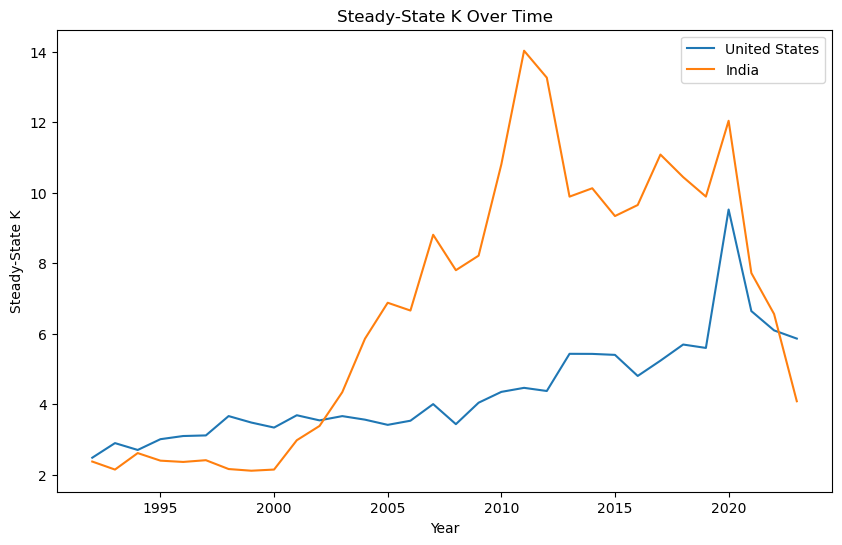

In [147]:
import matplotlib.pyplot as plt

# Select countries to plot
countries_to_plot = ["United States", "India"]

# Filter the dataframe for these countries
plot_df = df[df["Country Name"].isin(countries_to_plot)]

# Create a line plot of Steady-State K over time for the selected countries
fig, ax = plt.subplots(figsize=(10, 6))
for country in countries_to_plot:
    country_data = plot_df[plot_df["Country Name"] == country].sort_values("Year")
    ax.plot(country_data["Year"], country_data["Steady-State K"], label=country)

ax.set_xlabel("Year")
ax.set_ylabel("Steady-State K")
ax.set_title("Steady-State K Over Time")
ax.legend()
plt.show()


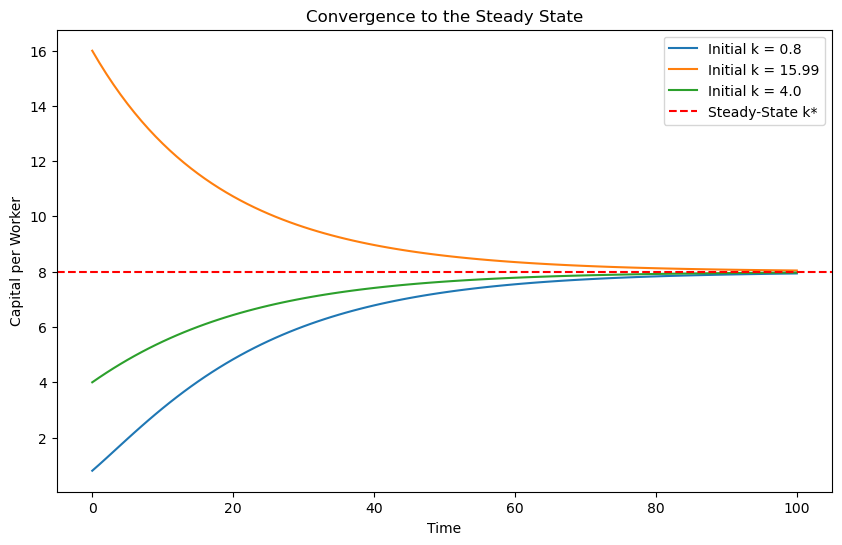

In [94]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
s = 0.3       # saving rate
delta = 0.05  # depreciation rate
n = 0.02      # population growth rate
alpha = 0.3   # capital share
A = 1         # TFP

# Compute steady-state capital per worker
k_star = ((s * A) / (n + delta))**(1/(1 - alpha))

# Let's say we have three economies with different initial conditions
initial_capitals = [0.1*k_star, 2*k_star, 0.5*k_star]  # some start below, some above

time_steps = 100
fig, ax = plt.subplots(figsize=(10,6))

for k0 in initial_capitals:
    k_path = [k0]
    k = k0
    for t in range(time_steps):
        # Law of motion: k_{t+1} = s A k_t^alpha + (1 - delta - n) k_t
        k = s*A*k**alpha + (1 - delta - n)*k
        k_path.append(k)
    ax.plot(k_path, label=f"Initial k = {round(k0, 2)}")

# Plot the steady-state line
ax.axhline(y=k_star, color='red', linestyle='--', label='Steady-State k*')

ax.set_xlabel("Time")
ax.set_ylabel("Capital per Worker")
ax.set_title("Convergence to the Steady State")
ax.legend()
plt.show()


In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1) Set parameters
A = 1
delta = 0.12
alpha = 0.33
s_fixed = 0.3
n_fixed = 0.02

# 2) Find the steady-state k using the fixed parameters
k_star = ((s_fixed * A) / (n_fixed + delta)) ** (1 / (1 - alpha))


# 3) Find the actu



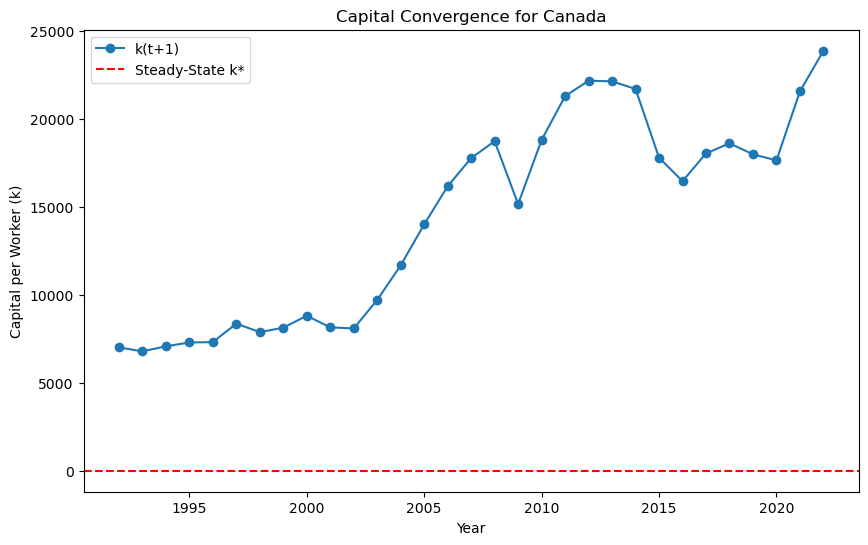

    Year          k(t)        k(t+1)  k* (Steady-State)
0   1992   7373.731777   7018.034740           8.776437
1   1993   7195.084910   6794.234487           8.776437
2   1994   7526.564944   7080.708142           8.776437
3   1995   7738.238027   7299.305712           8.776437
4   1996   7788.560607   7320.029985           8.776437
5   1997   8955.740088   8369.154246           8.776437
6   1998   8438.664897   7888.976139           8.776437
7   1999   8727.245888   8138.321454           8.776437
8   2000   9442.905953   8817.150641           8.776437
9   2001   8742.503078   8160.004038           8.776437
10  2002   8788.265205   8096.166665           8.776437
11  2003  10479.490520   9717.062563           8.776437
12  2004  12448.565498  11681.071604           8.776437
13  2005  14872.189247  14011.526321           8.776437
14  2006  17243.761584  16177.953098           8.776437
15  2007  19094.226472  17779.267301           8.776437
16  2008  20039.998551  18740.116805           8

In [154]:
def compute_k_t_plus_1_with_steady_state_and_plot(country_name):
    """
    Computes k(t+1) for a given country using the law of motion for capital per worker:
    k(t+1) = s * A * k(t)^alpha + (1 - delta - n) * k(t)

    Also adds a column for the steady-state k* and plots k(t+1) and k*.

    Parameters:
        country_name (str): The name of the country.

    Returns:
        pd.DataFrame: A DataFrame containing 'Year', 'k(t)', 'k(t+1)', and 'k*'.
    """
    # Constants
    A = 1
    alpha = 0.33
    delta = 0.05
    s_fixed = 0.3
    n_fixed = 0.02

    # Compute the steady-state k*
    k_star = ((s_fixed * A) / (n_fixed + delta)) ** (1 / (1 - alpha))

    # Filter the dataset for the given country
    country_data = df[df["Country Name"] == country_name].sort_values("Year")

    # Extract relevant columns
    years = country_data["Year"].values
    capital = country_data["Capital Stock"].values
    labor_force = country_data["Labour Force"].values
    savings_rate = country_data["Savings Rate"].values
    labor_growth_rate = country_data["Labour Force Growth Rate"].values

    # Compute k(t) = Capital Stock / Labour Force
    k_t = capital / labor_force

    # Initialize an array to store k(t+1)
    k_t_plus_1 = []

    # Apply the law of motion for each year
    for t in range(len(years) - 1):
        k_current = k_t[t]
        s_t = savings_rate[t]
        n_t = labor_growth_rate[t]

        # Law of motion: k(t+1) = s_t * A * k(t)^alpha + (1 - delta - n_t) * k(t)
        k_next = s_t * A * (k_current**alpha) + (1 - delta - n_t) * k_current
        k_t_plus_1.append(k_next)

    # The last year does not have k(t+1)
    k_t_plus_1.append(None)

    # Combine results into a DataFrame
    result_df = pd.DataFrame({
        "Year": years,
        "k(t)": k_t,
        "k(t+1)": k_t_plus_1,
        "k* (Steady-State)": [k_star] * len(years)  # Add steady-state value to all rows
    })

    # Plot k(t+1) and steady-state k*
    plt.figure(figsize=(10, 6))
    plt.plot(result_df["Year"], result_df["k(t+1)"], label="k(t+1)", marker="o")
    plt.axhline(y=k_star, color="r", linestyle="--", label="Steady-State k*")
    plt.xlabel("Year")
    plt.ylabel("Capital per Worker (k)")
    plt.title(f"Capital Convergence for {country_name}")
    plt.legend()
    plt.show()

    return result_df

# Example usage:
country_name = "Canada"
result = compute_k_t_plus_1_with_steady_state_and_plot(country_name)
print(result)


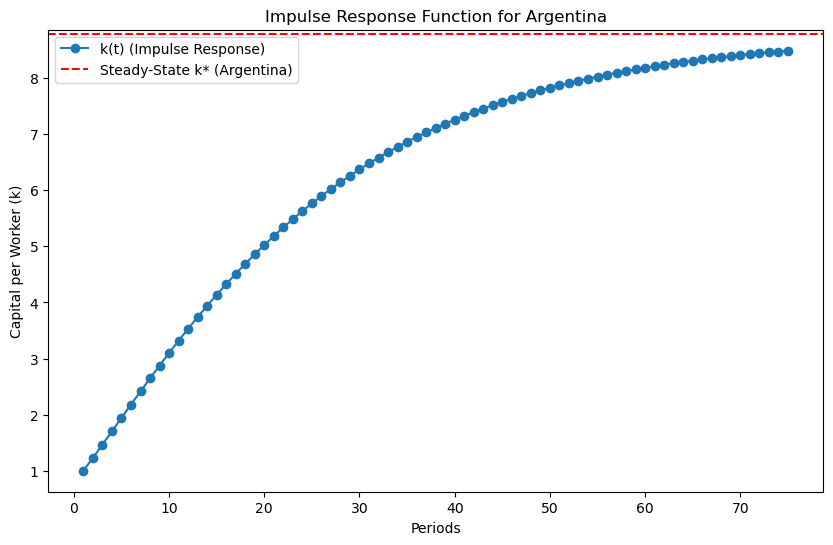

    Period      k(t)  Steady-State k*
0        1  1.000000         8.776437
1        2  1.230000         8.776437
2        3  1.465111         8.776437
3        4  1.702850         8.776437
4        5  1.941261         8.776437
..     ...       ...              ...
70      71  8.424733         8.776437
71      72  8.441116         8.776437
72      73  8.456741         8.776437
73      74  8.471643         8.776437
74      75  8.485854         8.776437

[75 rows x 3 columns]


In [151]:
import numpy as np
import matplotlib.pyplot as plt

def impulse_response_function(initial_k, country_name):
    """
    Computes and plots the impulse response function for a given country.

    Parameters:
        initial_k (float): Initial capital per worker (k_t).
        country_name (str): Name of the country.

    Returns:
        pd.DataFrame: A DataFrame containing the time path of k(t) and the steady-state k*.
    """
    # Constants
    A = 1
    alpha = 0.33
    delta = 0.05
    s_fixed = 0.3
    n_fixed = 0.02

    # Compute steady-state k*
    k_star = ((s_fixed * A) / (n_fixed + delta)) ** (1 / (1 - alpha))

    # Set the time horizon for the impulse response
    time_horizon = 75  # 50 periods
    years = np.arange(1, time_horizon + 1)

    # Initialize an array to store k(t)
    k_values = [initial_k]

    # Apply the law of motion iteratively
    for t in range(1, time_horizon):
        k_current = k_values[-1]
        # Law of motion: k(t+1) = s * A * k(t)^alpha + (1 - delta - n) * k(t)
        k_next = s_fixed * A * (k_current**alpha) + (1 - delta - n_fixed) * k_current
        k_values.append(k_next)

    # Plot the impulse response
    plt.figure(figsize=(10, 6))
    plt.plot(years, k_values, label="k(t) (Impulse Response)", marker="o")
    plt.axhline(y=k_star, color="r", linestyle="--", label=f"Steady-State k* ({country_name})")
    plt.xlabel("Periods")
    plt.ylabel("Capital per Worker (k)")
    plt.title(f"Impulse Response Function for {country_name}")
    plt.legend()
    plt.show()

    # Return results in a DataFrame
    import pandas as pd
    result_df = pd.DataFrame({
        "Period": years,
        "k(t)": k_values,
        "Steady-State k*": [k_star] * time_horizon
    })

    return result_df

# Example usage:
country = "Argentina"
initial_k_value = 1  # Example initial value for k(t)
result = impulse_response_function(initial_k_value, country)
print(result)


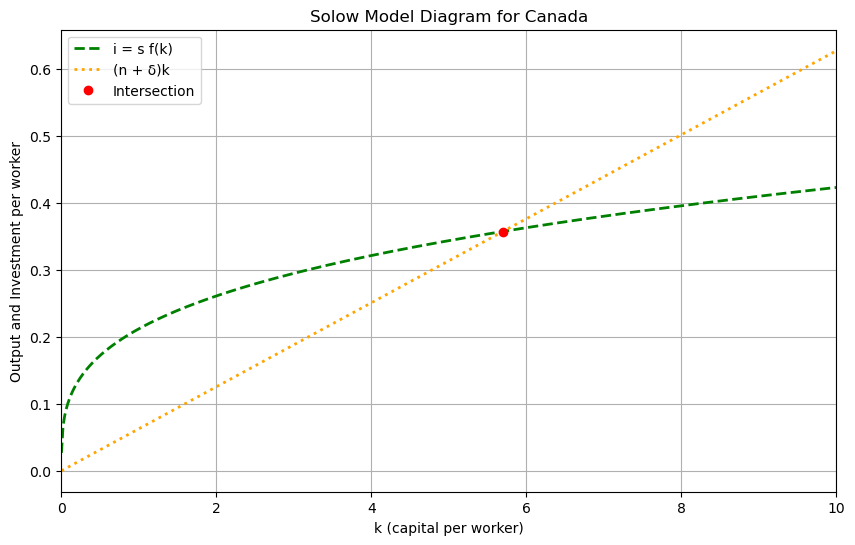

Intersection point:
k* = 5.69181362725451
i* = 0.35687793648566235


In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the merged dataset
df = pd.read_excel("Final_Dataset.xlsx")

# Choose a country
country_name = "Canada"

# Filter for the chosen country
country_data = df[df["Country Name"] == country_name].copy()
if country_data.empty:
    raise ValueError(f"No data found for {country_name}")

# Extract parameters from your dataset (averages to smooth out noise)
s = country_data["Savings Rate"].mean()   # Average savings rate
n = country_data["Labour Force Growth Rate"].mean()  # Average labor force growth rate

# Set model parameters
alpha = 0.3     # Capital share in production
delta = 0.05     # Depreciation rate
A = 1.0          # Technology level (assumed constant)

# Define a range of k (capital per worker) values for the plot: 0 < k < 10
k_values = np.linspace(0.001, 10, 500)  # start from a small positive number to avoid division issues

# Compute the functions
# y_values = A * (k_values ** alpha)  # Commented out as requested
y_values = A * (k_values ** alpha)
investment_values = s * y_values             # i = s f(k)
break_even_values = (n + delta) * k_values   # (n+δ)k

plt.figure(figsize=(10, 6))
# plt.plot(k_values, y_values, label="y = f(k) = A k^alpha", linewidth=2, linestyle='-') # Commented out as requested
plt.plot(k_values, investment_values, label="i = s f(k)", linewidth=2, linestyle='--', color='green')
plt.plot(k_values, break_even_values, label="(n + δ)k", linewidth=2, linestyle=':', color='orange')

plt.xlim(0, 10)
plt.title(f"Solow Model Diagram for {country_name}")
plt.xlabel("k (capital per worker)")
plt.ylabel("Output and Investment per worker")
plt.legend()
plt.grid(True)

# Numerically find the intersection point between the green and orange lines
diff = np.abs(investment_values - break_even_values)
idx = diff.argmin()  # index of the closest intersection
k_star = k_values[idx]
i_star = investment_values[idx]

# Add a dot at the intersection point
plt.plot(k_star, i_star, 'o', color='red', label="Intersection")

plt.legend()
plt.show()

# Print the intersection point
print("Intersection point:")
print("k* =", k_star)
print("i* =", i_star)
